In [1]:
#import all required packages for this analysis
import pandas as pd
import numpy as np
import os
import base64
import Levenshtein as lev
from fuzzywuzzy import process
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt
import time

In [2]:
#read raw input data 
input_file_path = '/Users/santoshkumar/Downloads/agoda'
file = os.path.join(input_file_path, 'mappinghotelsdataset.xlsx')

raw_df_partner1 = pd.read_excel(file, sheet_name='Partner1', keep_default_na=False)
df_partner1 = raw_df_partner1
raw_df_partner2 = pd.read_excel(file, sheet_name = 'Partner2', keep_default_na=False)
df_partner2 = raw_df_partner2

Cleaning the dataset for matching algo. Following steps:
make all lowercase -> remove spaces -> (remove comma, punctuation, etc)-> encode as utf-8 


In [3]:
# helper function to do preprocessing on string before fuzzy match 
def lowercase_removespace(df, col):
    df[col] = df.loc[:, col].map(lambda x: x.lower() if isinstance(x, str) else x).\
    map(lambda x: x.replace(' ','') if isinstance(x,str) else x).\
    map(lambda x: x.replace(',', '') if isinstance(x,str) else x).\
    map(lambda x: x.replace('.', '') if isinstance(x,str) else x)

    
# encode string to utf-8 for consistency
def encode_to_utf8(df, col):
    df[col] = df[col].map(lambda x: base64.b64encode(x.encode('utf-8')))
    
def decode_to_str(df, col):
    df[col] = df[col].map(lambda x: base64.b64decode(x))

In [4]:
# create a function which calculate best match for hotels in Partners1 sheet with Partners2. It takes
# Partners1 and Partners2 data as input and returns best match hotel from partner2 for each hotel in partner1
# along with matching score

# Starts with checking for exact match first. Model input takes two values ['lev', 'fuzzy']. 
# Default is Levenshtein distance model to map keys
def mapping(df_partner1, df_partner2, model = 'lev'):
    output = []
    country_list = [x for x in df_partner1['p1.country_code']]
    country_list = list(set(country_list))
    for country_code in country_list:
        partner1 = df_partner1[df_partner1['p1.country_code'] == country_code]
        partner2 = df_partner2[df_partner2['p2.country_code'] == country_code]
        for str1 in partner1['p1.mapping_key']:
            matching_score = []
            best_match = []
            for str2 in partner2['p2.mapping_key']:
                if str1 == str2:
                    ratio = 1.0
                    matching_score.append(ratio)
                    best_match.append(str2)
                else:
                    if model == 'lev':
                        ratio = lev.ratio(str1, str2)
                        matching_score.append(ratio)
                        best_match.append(str2)
                    elif model == 'fuzzy':
                        ratio = fuzz.token_set_ratio(str1, str2)/100.0
                        matching_score.append(ratio)
                        best_match.append(str2)                    
                        
            max_index = matching_score.index(max(matching_score))
            max_matching_score = matching_score[max_index]
            best_match_hotel = best_match[max_index]
            p1_key = partner1.loc[partner1['p1.mapping_key'] == str1,['p1.key']].iloc[0,0]
            p2_key = partner2.loc[partner2['p2.mapping_key'] == best_match_hotel, ['p2.key']].iloc[0,0]
            output.append([str1, p1_key, best_match_hotel, p2_key, 
                           country_code, max_matching_score]) 
    return output

## Evaluating the model we built above using example dataset

Create a training datset for our model. Using our model and data from partner1 in example file, we'll find its mapping in partner2 hotels. This mapping will be used to compare against actuall mapping in example file to evaluate our model

In [5]:
# load data and clean it for the model
df_example = pd.read_excel(file, sheet_name = 'examples', keep_default_na=False)
df_ex_partner1 = df_example[['p1.key', 'p1.hotel_name', 'p1.city_name',
               'p1.country_code', 'p1.hotel_address']]

#make all string lowercase and remove all spaces 
lowercase_removespace(df_ex_partner1, 'p1.hotel_name')
lowercase_removespace(df_ex_partner1, 'p1.city_name')
lowercase_removespace(df_ex_partner1, 'p1.hotel_address')
lowercase_removespace(df_ex_partner1, 'p1.country_code')

# create a mapping key which is concatenation of hotel name and hotel address. Encode it to utf-8 for consistency 
# This key will be used to calculate matching score 
df_ex_partner1 = df_ex_partner1.astype({'p1.hotel_name': str, 'p1.city_name' : str, 'p1.hotel_address' : str})
df_ex_partner1['p1.mapping_key'] = df_ex_partner1['p1.hotel_name'] + df_ex_partner1['p1.city_name']
encode_to_utf8(df_ex_partner1, 'p1.mapping_key')


# same steps for hotels in partners2 list. This is the list we will use for matching  
df_ex_partner2 = df_example[['p2.key', 'p2.hotel_name', 'p2.city_name',
               'p2.country_code', 'p2.hotel_address']]

lowercase_removespace(df_ex_partner2, 'p2.hotel_name')
lowercase_removespace(df_ex_partner2, 'p2.city_name')
lowercase_removespace(df_ex_partner2, 'p2.hotel_address')
lowercase_removespace(df_ex_partner2, 'p2.country_code')

df_ex_partner2 = df_ex_partner2.astype({'p2.hotel_name': str, 'p2.city_name' : str, 'p2.hotel_address' : str})
df_ex_partner2['p2.mapping_key'] = df_ex_partner2['p2.hotel_name'] + df_ex_partner2['p2.city_name']
encode_to_utf8(df_ex_partner2, 'p2.mapping_key')


<ipython-input-3-da43867a7479>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df.loc[:, col].map(lambda x: x.lower() if isinstance(x, str) else x).\


In [6]:
example_mapping_file = mapping(df_ex_partner1, df_ex_partner2, model = 'lev')
example_mapping = pd.DataFrame(example_mapping_file)
example_mapping.columns = ['p1.mapping_key','p1.key', 'p2.mapping_key','p2.key','country_code','score']

In [7]:
#evaluate how many were correctly matched;
#define a precision and recall: 
# precision: of all the predicted mappings, how many were correct matches
# recall: of all the mappings present in the data, how many were correctly predicted 
def precision_recall_tradeoff(train, test, threshold = 0.5):
    train = train[train['score'] >= threshold]
    train_df = train[['p1.key', 'p2.key']]
    test_df = test[['p1.key', 'p2.key']]
    
    eval_df = pd.merge(train_df, test_df, how ='inner', on =['p1.key', 'p2.key'])
    precision = len(eval_df)*100/(len(train_df))
    recall = len(eval_df)*100/(len(test_df))
    
    return precision, recall

In [8]:
test_df = df_example[['p1.key', 'p2.key']]
precision = []
recall = []
threshold = []
for i in range(101):
    th = 0.01*i
    pr, re = precision_recall_tradeoff(example_mapping, test_df, th)
    precision.append(pr)
    recall.append(re)
    threshold.append(th)

Text(0, 0.5, 'Precision')

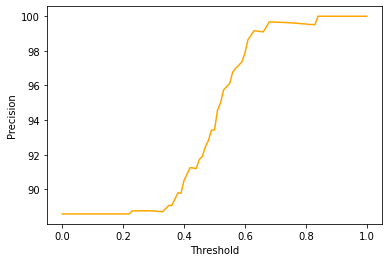

In [9]:
# plot precision for various threshold cut-off; select threshold which gives more than 98% precision 
plt.plot(threshold, precision, color ='orange')
plt.xlabel('Threshold')
plt.ylabel('Precision')

Text(0, 0.5, 'Precision')

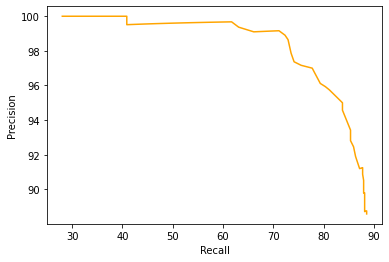

In [10]:
# plot precision recall tradeoff graph 
plt.plot(recall, precision, color = 'orange')
plt.xlabel('Recall')
plt.ylabel('Precision')

# Applying our winning model with optimal threshold on Partner1 sheet

In [11]:
ts = time.time()

In [12]:
#applying helper functions to clean data for string matching 
lowercase_removespace(df_partner1, 'p1.hotel_name')
lowercase_removespace(df_partner1, 'p1.city_name')
lowercase_removespace(df_partner1, 'p1.hotel_address')
lowercase_removespace(df_partner1, 'p1.country_code')

lowercase_removespace(df_partner2, 'p2.hotel_name')
lowercase_removespace(df_partner2, 'p2.city_name')
lowercase_removespace(df_partner2, 'p2.hotel_address')
lowercase_removespace(df_partner2, 'p2.country_code')

In [13]:
#convert hotel name and address to avoid any funny behaviour
df_partner1 = df_partner1.astype({'p1.hotel_name': str, 'p1.city_name' : str, 'p1.hotel_address': str})
df_partner2 = df_partner2.astype({'p2.hotel_name': str, 'p2.city_name' : str, 'p2.hotel_address': str})

In [14]:
# create a mapping key which is concatenation of hotel name and hotel address. 
# This key will be used to calculate matching score 
df_partner1['p1.mapping_key'] = df_partner1['p1.hotel_name'] + df_partner1['p1.city_name']
df_partner2['p2.mapping_key'] = df_partner2['p2.hotel_name'] + df_partner2['p2.city_name']

# using helper function to encode string to utf-8 
encode_to_utf8(df_partner1, 'p1.mapping_key')
encode_to_utf8(df_partner2, 'p2.mapping_key')

In [15]:
best_mapping_file = mapping(df_partner1, df_partner2, model = 'lev')

In [16]:
df_mapping = pd.DataFrame(best_mapping_file)

In [17]:
df_mapping.columns = ['p1.mapping_key','p1.key', 'p2.mapping_key','p2.key','country_code','score']

In [18]:
decode_to_str(df_mapping, 'p1.mapping_key')
decode_to_str(df_mapping, 'p2.mapping_key')

In [19]:
submission_df = df_mapping[df_mapping['score'] >= .61]
submission_df = submission_df[['p1.key', 'p2.key']]
submission_df.to_csv('mappings.csv', index = False)
len(submission_df)

8283

In [20]:
#create a file with low score for manual inspection 
low_score_df = df_mapping[df_mapping['score']<39][['p1.key', 'p2.key']]
low_score_df = low_score_df.merge(raw_df_partner1, how = 'left', on = ['p1.key'])
low_score_df = low_score_df.merge(raw_df_partner2, how = 'left', on = ['p2.key'])

low_score_df.to_excel('mapping_low_score.xlsx', index = False)

In [21]:
tc = time.time()
print('time taken to run:{}'.format(tc-ts))

time taken to run:31.526336908340454
